In [30]:
!pip install torch torchvision pandas matplotlib


In [3]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

## Creating Training data's Dataframe

In [5]:
def create_image_dataframe(root_dir, label_map={"o.png": 0, "g.png": 1}):
    data = [] ##list to store every image in the form of (path,label)
    for subfolder in os.listdir(root_dir): ##returns a list of all files and folders that are directly inside the directory root_dir
        folder_path = os.path.join(root_dir, subfolder) ##joins the root_dir path with subfolder name, i.e assign a unique path to each subfolder present inside the root_dir
        if not os.path.isdir(folder_path): ##skip anything that’s not a folder
            continue
        for image_name in ["o.png", "g.png"]:
            image_path = os.path.join(folder_path, image_name) ##creates a path for each image, i.e two inside a subfolder
            if os.path.exists(image_path): ##validation check for particular image, i.e if an image from that particular created path exits or not
                label = label_map[image_name] ##assigns the label to image using the above(label_map) dictionary
                data.append((image_path, label)) ##Add that particular tuple to the list
    return pd.DataFrame(data, columns=["image_path", "label"]) ##Finally return the tuple by converting it into a dataframe

train_df = create_image_dataframe("/Users/deepanshu/Ghibli_Classifier/Ghibli/training")
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["label"], random_state=42)
train_df.shape
train_df.head()

,image_path,label
155,/Users/deepanshu/Ghibli_Classifier/Ghibli/trai...,1
226,/Users/deepanshu/Ghibli_Classifier/Ghibli/trai...,0
76,/Users/deepanshu/Ghibli_Classifier/Ghibli/trai...,0
98,/Users/deepanshu/Ghibli_Classifier/Ghibli/trai...,0
209,/Users/deepanshu/Ghibli_Classifier/Ghibli/trai...,1


## Verify labelling logic

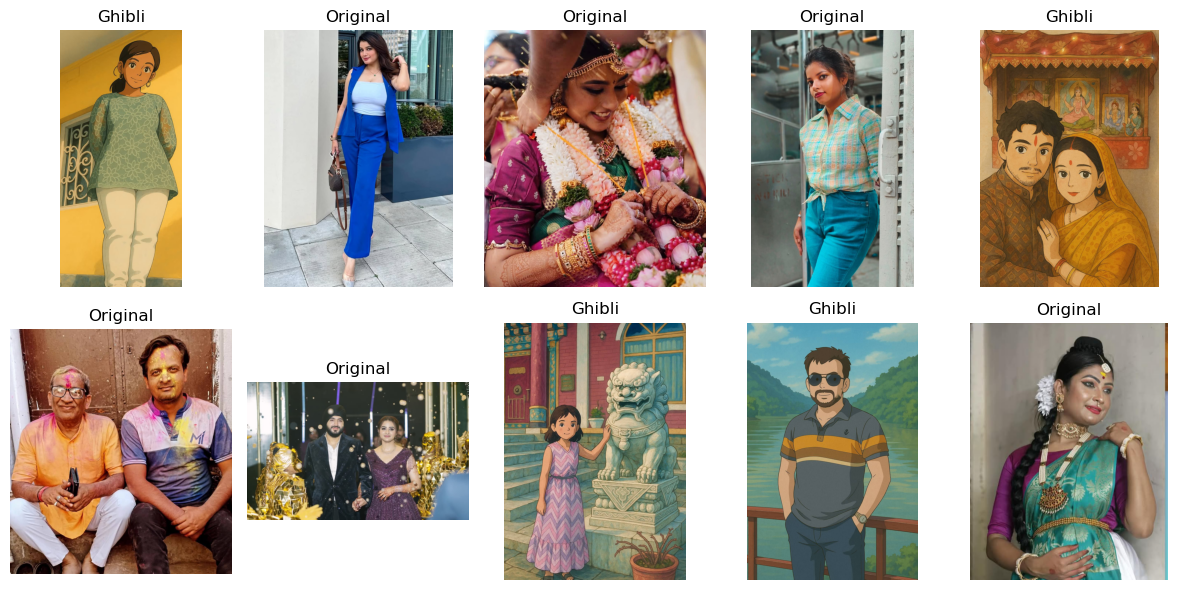

In [69]:
def show_sample_images(df, num_samples=10): ##num_samples - number of images to be displayed as sample
    plt.figure(figsize=(12, 6)) ##setting up the canvas to display
    
    for i in range(num_samples):
        image_path = df.iloc[i]['image_path'] ##From the data frame((train_df), extract the path of that particular image
        label = df.iloc[i]['label'] ##From the data frame(train_df), extract the label of that particular image
        image = Image.open(image_path).convert("RGB") ##Opens the image at image_path and making it a three channel image 

        plt.subplot(2, 5, i + 1) ##Split the canvas into 2 rows and 5 columns and assign every image location in canvas.
        plt.imshow(image) ##display the image
        plt.title("Ghibli" if label == 1 else "Original") ##Set the image title accordingly
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images(train_df)

## Custom Dataset class to load and preprocess Ghibli images for model training

In [72]:
class GhibliDataset(Dataset): ##GhibliDataset class inherits from PyTorch's built in Dataset class 
    def __init__(self, dataframe, transform=None): ##Constructor
        self.dataframe = dataframe ## Dataframe - DataFrame, that consists our image data, for ex. train_df
        self.transform = transform ## Transform - Any preprocessing(resizing,normailization,etc.) needs to be performed or not

    def __len__(self):
        return len(self.dataframe) ##Tells PyTorch how many total items are in this dataset.

    def __getitem__(self, idx): ##This defines how to get a single item (image and label), idx - That particular number of row
        img_path = self.dataframe.iloc[idx, 0] ##fetching the image path (column 0) at row number idx
        label = self.dataframe.iloc[idx, 1] ##Fetching the label (column 1) at the same row
        image = Image.open(img_path).convert("RGB") ##Opens the image at that particular path
        if self.transform: ##Apply the transformation if passed
            image = self.transform(image)
        return image, label

# Define transformations for training and creating Dataloaders

In [75]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(           # Normalize with ImageNet mean and std(making brightness, contrast, etc.) of all the images similar
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
train_dataset = GhibliDataset(dataframe=train_df, transform=transform) ##List that stores all the transformed images in the form of image,label
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) ##Creating the Dataloader(Accessing the list - train_dataset and picking up 32 images in shuffled order)
val_dataset = GhibliDataset(dataframe=val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Load the Pre-trained Model (ResNet18)

In [78]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

##Loading the pretrained ResNet18 model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

##Freeze early layers (optional, useful for transfer learning)
for param in model.parameters():
    param.requires_grad = False 

##Replace the final fully connected layer to match our 2 output classes
num_features = model.fc.in_features ##It fetches the number of input features going into the final fc layer
model.fc = nn.Linear(num_features, 2)  ##2 classes: Original or Ghibli

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Define Loss Function & Optimizer

In [81]:
import torch.optim as optim
import torch.nn as nn

## Loss function
criterion = nn.CrossEntropyLoss()

## Optimizer (we'll only update the last layer's weights)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

## Training Loop

In [84]:
num_epochs = 10  ##number of training passes

for epoch in range(num_epochs):
    model.train()  ## Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()              # Clear previous gradients
        outputs = model(images)            # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                    # Backpropagation
        optimizer.step()                   # Update weights

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%\n")


Epoch [1/10], Loss: 0.6145
Validation Accuracy: 67.86%

Epoch [2/10], Loss: 0.4798
Validation Accuracy: 78.57%

Epoch [3/10], Loss: 0.3886
Validation Accuracy: 89.29%

Epoch [4/10], Loss: 0.3124
Validation Accuracy: 94.64%

Epoch [5/10], Loss: 0.2994
Validation Accuracy: 91.07%

Epoch [6/10], Loss: 0.2390
Validation Accuracy: 91.07%

Epoch [7/10], Loss: 0.2333
Validation Accuracy: 91.07%

Epoch [8/10], Loss: 0.2141
Validation Accuracy: 98.21%

Epoch [9/10], Loss: 0.1788
Validation Accuracy: 94.64%

Epoch [10/10], Loss: 0.1784
Validation Accuracy: 92.86%



## Load saved weights

In [87]:
torch.save(model.state_dict(), "/Users/deepanshu/Ghibli_Classifier/model.pth")
print("Model saved properly.")

Model saved properly.


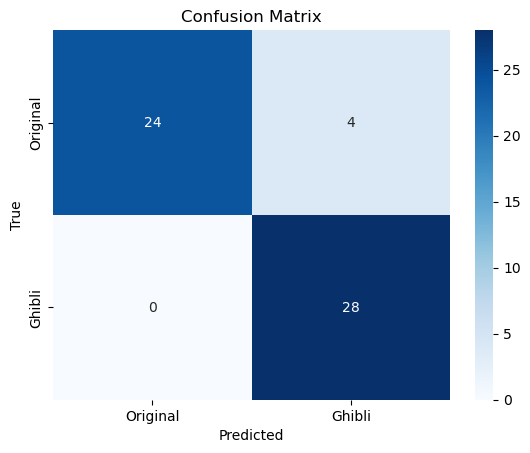

              precision    recall  f1-score   support

    Original       1.00      0.86      0.92        28
      Ghibli       0.88      1.00      0.93        28

    accuracy                           0.93        56
   macro avg       0.94      0.93      0.93        56
weighted avg       0.94      0.93      0.93        56



In [89]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Collect predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Original", "Ghibli"], yticklabels=["Original", "Ghibli"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=["Original", "Ghibli"]))


## Prediction

In [92]:
from PIL import Image
import torch
from torchvision import transforms

# Define the same transforms used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Prediction function using the trained model
def predict_image(image_path, model):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    label = predicted.item()
    return "Ghibli" if label == 1 else "Original"